This Notebook illustrates the usage of OpenMC's multi-group calculational mode with the Python API. This example notebook creates and executes the 2-D [C5G7](https://www.oecd-nea.org/science/docs/2003/nsc-doc2003-16.pdf) benchmark model using the `openmc.MGXSLibrary` class to create the supporting data library on the fly.

# Generate MGXS Library

In [1]:
import os

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

import openmc

%matplotlib inline

We will now create the multi-group library using data directly from Appendix A of the C5G7 benchmark documentation. All of the data below will be created at 294K, consistent with the benchmark.

This notebook will first begin by setting the group structure and building the data for UO2.

*Note*: Most users familiar with deterministic transport libraries are already familiar with the idea of entering one scattering matrix for every order (i.e. scattering order as the outer dimension). However, the shape of OpenMC's scattering matrix entry is instead [Incoming groups, Outgoing Groups, Scattering Order] to best enable other scattering representations. We will follow the more familiar approach in this notebook, and then use numpy's `numpy.rollaxis` function to change the ordering to what we need (scattering order on the inner dimension).


In [2]:
# Create a 7-group structure with arbitrary boundaries (the specific boundaries are unimportant)
groups = openmc.mgxs.EnergyGroups(np.logspace(-5, 7, 8))

uo2_xsdata = openmc.XSdata('uo2', groups)
uo2_xsdata.order = 0

# When setting the data let the object know you are setting the data for a temperature of 294K.
uo2_xsdata.set_total([1.77949E-1, 3.29805E-1, 4.80388E-1, 5.54367E-1,
                      3.11801E-1, 3.95168E-1, 5.64406E-1], temperature=294.)

uo2_xsdata.set_absorption([8.0248E-03, 3.7174E-3, 2.6769E-2, 9.6236E-2,
                           3.0020E-02, 1.1126E-1, 2.8278E-1], temperature=294.)
uo2_xsdata.set_fission([7.21206E-3, 8.19301E-4, 6.45320E-3, 1.85648E-2,
                        1.78084E-2, 8.30348E-2, 2.16004E-1], temperature=294.)

uo2_xsdata.set_nu_fission([2.005998E-2, 2.027303E-3, 1.570599E-2, 4.518301E-2,
                           4.334208E-2, 2.020901E-1, 5.257105E-1], temperature=294.)

uo2_xsdata.set_chi([5.87910E-1, 4.11760E-1, 3.39060E-4, 1.17610E-7,
                    0.00000E-0, 0.00000E-0, 0.00000E-0], temperature=294.)

# The scattering matrix is ordered with incoming groups as rows and outgoing groups as columns
# (i.e., above the diagonal is up-scattering).
scatter_matrix = \
    [[[1.27537E-1, 4.23780E-2, 9.43740E-6, 5.51630E-9, 0.00000E-0, 0.00000E-0, 0.00000E-0],
      [0.00000E-0, 3.24456E-1, 1.63140E-3, 3.14270E-9, 0.00000E-0, 0.00000E-0, 0.00000E-0],
      [0.00000E-0, 0.00000E-0, 4.50940E-1, 2.67920E-3, 0.00000E-0, 0.00000E-0, 0.00000E-0],
      [0.00000E-0, 0.00000E-0, 0.00000E-0, 4.52565E-1, 5.56640E-3, 0.00000E-0, 0.00000E-0],
      [0.00000E-0, 0.00000E-0, 0.00000E-0, 1.25250E-4, 2.71401E-1, 1.02550E-2, 1.00210E-8],
      [0.00000E-0, 0.00000E-0, 0.00000E-0, 0.00000E-0, 1.29680E-3, 2.65802E-1, 1.68090E-2],
      [0.00000E-0, 0.00000E-0, 0.00000E-0, 0.00000E-0, 0.00000E-0, 8.54580E-3, 2.73080E-1]]]
scatter_matrix = np.array(scatter_matrix)
scatter_matrix = np.rollaxis(scatter_matrix, 0, 3)
uo2_xsdata.set_scatter_matrix(scatter_matrix, temperature=294.)

Now that the UO2 data has been created, we can move on to the remaining materials using the same process.

However, we will actually skip repeating the above for now.  Our simulation will instead use the `c5g7.h5` file that has already been created using exactly the same logic as above, but for the remaining materials in the benchmark problem.

For now we will show how you would use the `uo2_xsdata` information to create an `openmc.MGXSLibrary` object and write to disk.

In [3]:
# Initialize the library
mg_cross_sections_file = openmc.MGXSLibrary(groups)

# Add the UO2 data to it
mg_cross_sections_file.add_xsdata(uo2_xsdata)

# And write to disk
mg_cross_sections_file.export_to_hdf5('mgxs.h5')

# Generate 2-D C5G7 Problem Input Files

To build the actual 2-D model, we will first begin by creating the `materials.xml` file.

First we need to define materials that will be used in the problem. In other notebooks, either `openmc.Nuclides` or `openmc.Elements` were created at the equivalent stage. We can do that in multi-group mode as well.  However, multi-group cross-sections are sometimes provided as macroscopic cross-sections; the C5G7 benchmark data are macroscopic. In this case, we can instead use `openmc.Macroscopic` objects to in-place of `openmc.Nuclides` or `openmc.Elements`.

`openmc.Macroscopic`, unlike `openmc.Nuclides` and `openmc.Elements` objects, do not need to be provided enough information to calculate number densities, as no number densities are needed.

When assigning `openmc.Macroscopic` objects to `openmc.Material` objects, the density can still be scaled by setting the density to a value that is not 1.0. This would be useful, for example, when slightly perturbing the density of water due to a small change in temperature (while of course ignoring any resultant spectral shift). The density of a macroscopic dataset is set to 1.0 in the `openmc.Material` object by default when an `openmc.Macroscopic` dataset is used; so we will show its use the first time and then afterwards it will not be required.

Aside from these differences, the following code is very similar to similar code in other OpenMC example Notebooks.

In [4]:
# For every cross section data set in the library, assign an openmc.Macroscopic object to a material
materials = {}
for xs in ['uo2', 'mox43', 'mox7', 'mox87', 'fiss_chamber', 'guide_tube', 'water']:
    materials[xs] = openmc.Material(name=xs)
    materials[xs].set_density('macro', 1.)
    materials[xs].add_macroscopic(openmc.Macroscopic(xs))

Now we can go ahead and produce a `materials.xml` file for use by OpenMC

In [5]:
# Instantiate a Materials collection, register all Materials, and export to XML
materials_file = openmc.Materials(materials.values())

# Set the location of the cross sections file to our pre-written set
materials_file.cross_sections = 'c5g7.h5'

materials_file.export_to_xml()

Our next step will be to create the geometry information needed for our assembly and to write that to the `geometry.xml` file.

We will begin by defining the surfaces, cells, and universes needed for each of the individual fuel pins, guide tubes, and fission chambers.

In [6]:
# Create the surface used for each pin
pin_surf = openmc.ZCylinder(x0=0, y0=0, R=0.54, name='pin_surf')

# Create the cells which will be used to represent each pin type.
cells = {}
universes = {}
for material in materials.values():
    # Create the cell for the material inside the cladding
    cells[material.name] = openmc.Cell(name=material.name)
    # Assign the half-spaces to the cell
    cells[material.name].region = -pin_surf
    # Register the material with this cell
    cells[material.name].fill = material
    
    # Repeat the above for the material outside the cladding (i.e., the moderator)
    cell_name = material.name + '_moderator'
    cells[cell_name] = openmc.Cell(name=cell_name)
    cells[cell_name].region = +pin_surf
    cells[cell_name].fill = materials['water']
    
    # Finally add the two cells we just made to a Universe object
    universes[material.name] = openmc.Universe(name=material.name)
    universes[material.name].add_cells([cells[material.name], cells[cell_name]])

The next step is to take our universes (representing the different pin types) and lay them out in a lattice to represent the assembly types

In [7]:
lattices = {}

# Instantiate the UO2 Lattice
lattices['UO2 Assembly'] = openmc.RectLattice(name='UO2 Assembly')
lattices['UO2 Assembly'].dimension = [17, 17]
lattices['UO2 Assembly'].lower_left = [-10.71, -10.71]
lattices['UO2 Assembly'].pitch = [1.26, 1.26]
u = universes['uo2']
g = universes['guide_tube']
f = universes['fiss_chamber']
lattices['UO2 Assembly'].universes = \
    [[u, u, u, u, u, u, u, u, u, u, u, u, u, u, u, u, u],
     [u, u, u, u, u, u, u, u, u, u, u, u, u, u, u, u, u],
     [u, u, u, u, u, g, u, u, g, u, u, g, u, u, u, u, u],
     [u, u, u, g, u, u, u, u, u, u, u, u, u, g, u, u, u],
     [u, u, u, u, u, u, u, u, u, u, u, u, u, u, u, u, u],
     [u, u, g, u, u, g, u, u, g, u, u, g, u, u, g, u, u],
     [u, u, u, u, u, u, u, u, u, u, u, u, u, u, u, u, u],
     [u, u, u, u, u, u, u, u, u, u, u, u, u, u, u, u, u],
     [u, u, g, u, u, g, u, u, f, u, u, g, u, u, g, u, u],
     [u, u, u, u, u, u, u, u, u, u, u, u, u, u, u, u, u],
     [u, u, u, u, u, u, u, u, u, u, u, u, u, u, u, u, u],
     [u, u, g, u, u, g, u, u, g, u, u, g, u, u, g, u, u],
     [u, u, u, u, u, u, u, u, u, u, u, u, u, u, u, u, u],
     [u, u, u, g, u, u, u, u, u, u, u, u, u, g, u, u, u],
     [u, u, u, u, u, g, u, u, g, u, u, g, u, u, u, u, u],
     [u, u, u, u, u, u, u, u, u, u, u, u, u, u, u, u, u],
     [u, u, u, u, u, u, u, u, u, u, u, u, u, u, u, u, u]]
    
# Create a containing cell and universe
cells['UO2 Assembly'] = openmc.Cell(name='UO2 Assembly')
cells['UO2 Assembly'].fill = lattices['UO2 Assembly']
universes['UO2 Assembly'] = openmc.Universe(name='UO2 Assembly')
universes['UO2 Assembly'].add_cell(cells['UO2 Assembly'])

# Instantiate the MOX Lattice
lattices['MOX Assembly'] = openmc.RectLattice(name='MOX Assembly')
lattices['MOX Assembly'].dimension = [17, 17]
lattices['MOX Assembly'].lower_left = [-10.71, -10.71]
lattices['MOX Assembly'].pitch = [1.26, 1.26]
m = universes['mox43']
n = universes['mox7']
o = universes['mox87']
g = universes['guide_tube']
f = universes['fiss_chamber']
lattices['MOX Assembly'].universes = \
    [[m, m, m, m, m, m, m, m, m, m, m, m, m, m, m, m, m],
     [m, n, n, n, n, n, n, n, n, n, n, n, n, n, n, n, m],
     [m, n, n, n, n, g, n, n, g, n, n, g, n, n, n, n, m],
     [m, n, n, g, n, o, o, o, o, o, o, o, n, g, n, n, m],
     [m, n, n, n, o, o, o, o, o, o, o, o, o, n, n, n, m],
     [m, n, g, o, o, g, o, o, g, o, o, g, o, o, g, n, m],
     [m, n, n, o, o, o, o, o, o, o, o, o, o, o, n, n, m],
     [m, n, n, o, o, o, o, o, o, o, o, o, o, o, n, n, m],
     [m, n, g, o, o, g, o, o, f, o, o, g, o, o, g, n, m],
     [m, n, n, o, o, o, o, o, o, o, o, o, o, o, n, n, m],
     [m, n, n, o, o, o, o, o, o, o, o, o, o, o, n, n, m],
     [m, n, g, o, o, g, o, o, g, o, o, g, o, o, g, n, m],
     [m, n, n, n, o, o, o, o, o, o, o, o, o, n, n, n, m],
     [m, n, n, g, n, o, o, o, o, o, o, o, n, g, n, n, m],
     [m, n, n, n, n, g, n, n, g, n, n, g, n, n, n, n, m],
     [m, n, n, n, n, n, n, n, n, n, n, n, n, n, n, n, m],
     [m, m, m, m, m, m, m, m, m, m, m, m, m, m, m, m, m]]
    
# Create a containing cell and universe
cells['MOX Assembly'] = openmc.Cell(name='MOX Assembly')
cells['MOX Assembly'].fill = lattices['MOX Assembly']
universes['MOX Assembly'] = openmc.Universe(name='MOX Assembly')
universes['MOX Assembly'].add_cell(cells['MOX Assembly'])
    
# Instantiate the reflector Lattice
lattices['Reflector Assembly'] = openmc.RectLattice(name='Reflector Assembly')
lattices['Reflector Assembly'].dimension = [1,1]
lattices['Reflector Assembly'].lower_left = [-10.71, -10.71]
lattices['Reflector Assembly'].pitch = [21.42, 21.42]
lattices['Reflector Assembly'].universes = [[universes['water']]]

# Create a containing cell and universe
cells['Reflector Assembly'] = openmc.Cell(name='Reflector Assembly')
cells['Reflector Assembly'].fill = lattices['Reflector Assembly']
universes['Reflector Assembly'] = openmc.Universe(name='Reflector Assembly')
universes['Reflector Assembly'].add_cell(cells['Reflector Assembly'])

Let's now create the core layout in a 3x3 lattice where each lattice position is one of the assemblies we just defined.

After that we can create the final cell to contain the entire core.

In [8]:
lattices['Core'] = openmc.RectLattice(name='3x3 core lattice')
lattices['Core'].dimension= [3, 3]
lattices['Core'].lower_left = [-32.13, -32.13]
lattices['Core'].pitch = [21.42, 21.42]
r = universes['Reflector Assembly']
u = universes['UO2 Assembly']
m = universes['MOX Assembly']
lattices['Core'].universes = [[u, m, r],
                              [m, u, r],
                              [r, r, r]]

# Create boundary planes to surround the geometry
min_x = openmc.XPlane(x0=-32.13, boundary_type='reflective')
max_x = openmc.XPlane(x0=+32.13, boundary_type='vacuum')
min_y = openmc.YPlane(y0=-32.13, boundary_type='vacuum')
max_y = openmc.YPlane(y0=+32.13, boundary_type='reflective')

# Create root Cell
root_cell = openmc.Cell(name='root cell')
root_cell.fill = lattices['Core']

# Add boundary planes
root_cell.region = +min_x & -max_x & +min_y & -max_y

# Create root Universe
root_universe = openmc.Universe(name='root universe', universe_id=0)
root_universe.add_cell(root_cell)

Before we commit to the geometry, we should view it using the Python API's plotting capability

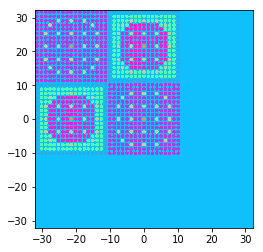

In [9]:
root_universe.plot(center=(0., 0., 0.), width=(3 * 21.42, 3 * 21.42), pixels=(500, 500),
                   color_by='material')

OK, it looks pretty good, let's go ahead and write the file

In [10]:
# Create Geometry and set root Universe
geometry = openmc.Geometry()
geometry.root_universe = root_universe

# Export to "geometry.xml"
geometry.export_to_xml()

We can now create the tally file information. The tallies will be set up to  give us the pin powers in this notebook. We will do this with a mesh filter, with one mesh cell per pin.

In [11]:
tallies_file = openmc.Tallies()

# Instantiate a tally Mesh
mesh = openmc.Mesh()
mesh.type = 'regular'
mesh.dimension = [17 * 2, 17 * 2]
mesh.lower_left = [-32.13, -10.71]
mesh.upper_right = [+10.71, +32.13]

# Instantiate tally Filter
mesh_filter = openmc.MeshFilter(mesh)

# Instantiate the Tally
tally = openmc.Tally(name='mesh tally')
tally.filters = [mesh_filter]
tally.scores = ['fission']

# Add tally to collection
tallies_file.append(tally)

# Export all tallies to a "tallies.xml" file
tallies_file.export_to_xml()

With the geometry and materials finished, we now just need to define simulation parameters for the `settings.xml` file. Note the use of the `energy_mode` attribute of our `settings_file` object. This is used to tell OpenMC that we intend to run in multi-group mode instead of the default continuous-energy mode. If we didn't specify this but our cross sections file was not a continuous-energy data set, then OpenMC would complain.

This will be a relatively coarse calculation with only 500,000 active histories. A benchmark-fidelity run would of course require many more!

In [12]:
# OpenMC simulation parameters
batches = 150
inactive = 50
particles = 5000

# Instantiate a Settings object
settings_file = openmc.Settings()
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles

# Tell OpenMC this is a multi-group problem
settings_file.energy_mode = 'multi-group'

# Set the verbosity to 6 so we dont see output for every batch
settings_file.verbosity = 6

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-32.13, -10.71, -1e50, 10.71, 32.13, 1e50]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings_file.source = openmc.source.Source(space=uniform_dist)

# Tell OpenMC we want to run in eigenvalue mode
settings_file.run_mode = 'eigenvalue'

# Export to "settings.xml"
settings_file.export_to_xml()

Let's go ahead and execute the simulation! You'll notice that the output for multi-group mode is exactly the same as for continuous-energy. The differences are all under the hood.

In [13]:
# Run OpenMC
openmc.run()


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

0

# Results Visualization

Now that we have run the simulation, let's look at the fission rate and flux tallies that we tallied.

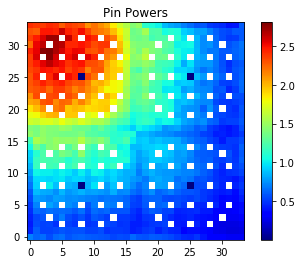

In [14]:
# Load the last statepoint file and keff value
sp = openmc.StatePoint('statepoint.' + str(batches) + '.h5')

# Get the OpenMC pin power tally data
mesh_tally = sp.get_tally(name='mesh tally')
fission_rates = mesh_tally.get_values(scores=['fission'])

# Reshape array to 2D for plotting
fission_rates.shape = mesh.dimension

# Normalize to the average pin power
fission_rates /= np.mean(fission_rates)

# Force zeros to be NaNs so their values are not included when matplotlib calculates
# the color scale
fission_rates[fission_rates == 0.] = np.nan

# Plot the pin powers and the fluxes
plt.figure()
plt.imshow(fission_rates, interpolation='none', cmap='jet', origin='lower')
plt.colorbar()
plt.title('Pin Powers')
plt.show()


There we have it! We have just successfully run the C5G7 benchmark model!